In [1]:
import pandas as pd

df = pd.read_csv("./dataset/Training_set.csv")
df.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [2]:
print(f"Total categories: {df['label'].unique().shape[0]}")

Total categories: 75


In [3]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df["label"] = encoder.fit_transform(df["label"])
df.head()

,filename,label
0,Image_1.jpg,66
1,Image_2.jpg,0
2,Image_3.jpg,12
3,Image_4.jpg,44
4,Image_5.jpg,33


In [4]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["label"], axis=1, inplace=False)
y = df[["label"]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=True, stratify=y
)

train_labels = pd.concat([X_train, y_train], axis=1, ignore_index=False)
val_labels = pd.concat([X_test, y_test], axis=1, ignore_index=False)

print(f"Total samples in train dataset: {train_labels.shape[0]}")
print(f"Total samples in validation dataset: {val_labels.shape[0]}")

Total samples in train dataset: 5849
Total samples in validation dataset: 650


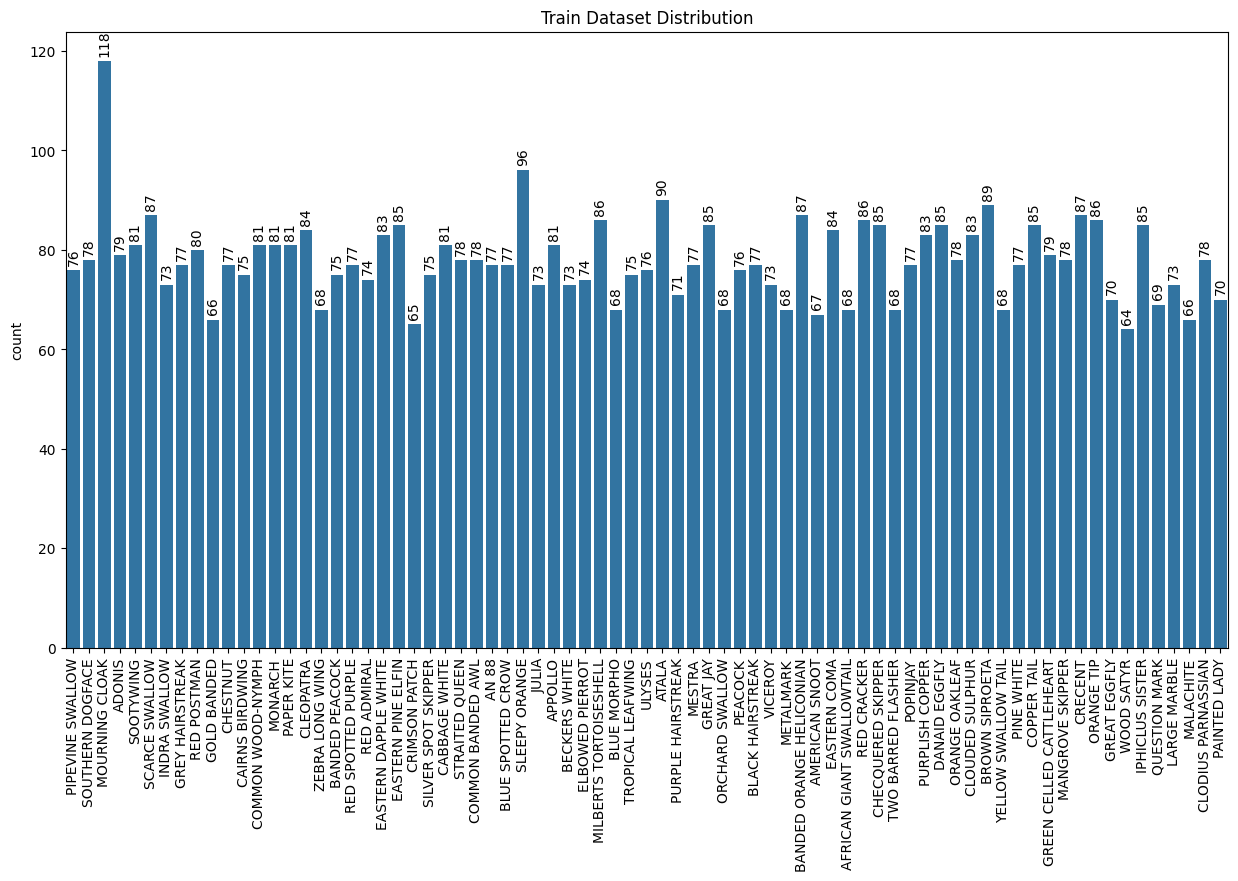

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns

_ = plt.figure(figsize=(15, 8), dpi=100)

ax = sns.countplot(x=encoder.inverse_transform(train_labels["label"]))
plt.xticks(rotation=90)
for p in ax.patches:
    x = p.get_x() + p.get_width() / 2.
    y = p.get_height()
    ax.annotate(int(y), (x, y+1), ha="center", va="bottom", rotation=90)
    ax.set_title("Train Dataset Distribution")

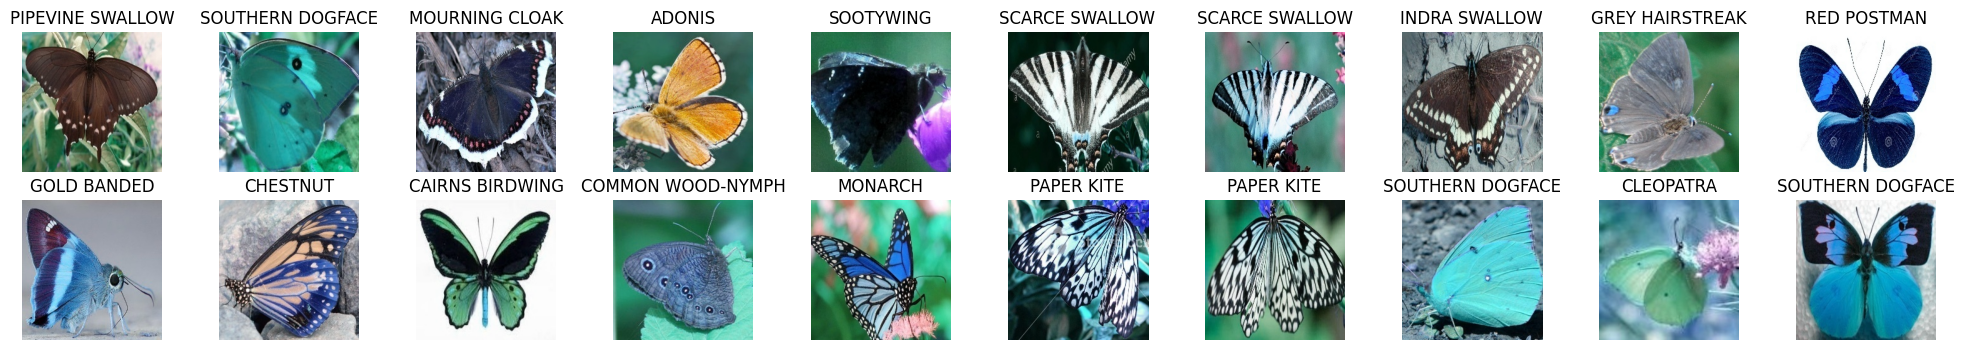

In [6]:
import cv2
from matplotlib import pyplot as plt

plt.figure(figsize=(25, 4), dpi=100)

for idx, fn in enumerate(train_labels["filename"].unique().tolist()[:20]):
    plt.subplot(2, 10, idx+1)
    img = cv2.imread(f"dataset/train/{fn}")
    plt.imshow(img)
    plt.axis("off")
    label = train_labels[train_labels["filename"] == fn]["label"].tolist()
    plt.title(encoder.inverse_transform(label)[0])

In [7]:
from torch import nn
from torchvision import transforms as T

train_transforms_ = T.Compose([
    T.ToPILImage(),
    # Original size: 224 x 224
    T.Resize((56, 56)),
    T.RandomApply(
        nn.ModuleList([
            T.ColorJitter(brightness=0.3),
        ]), p=0.4
    ),
    T.RandomGrayscale(p=0.2),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=20),
    T.RandomAdjustSharpness(sharpness_factor=0.5, p=0.5),
    T.RandomAutocontrast(p=0.5),
    T.ToTensor(),
    T.Normalize(
        mean=[0.480, 0.465, 0.337],
        std=[0.236, 0.231, 0.223]
    )
])

test_transforms_ = T.Compose([
    T.ToPILImage(),
    T.Resize((56, 56)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.480, 0.465, 0.337],
        std=[0.236, 0.231, 0.223]
    )
])

In [8]:
from pathlib import Path
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class ButterflyDataset(Dataset):
    def __init__(self, images_dir, labels_df: pd.DataFrame=None, transform=None):
        super().__init__()
        self.transform = transform
        self.labels = labels_df

        self.image_files = []
        for image_path in Path(images_dir).iterdir():
            if self.labels is None or (
                self.labels is not None and
                image_path.name in self.labels["filename"].to_list()
            ):
                self.image_files.append(image_path)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        if self.labels is not None:
            label = self.labels[
                self.labels["filename"] == self.image_files[index].name
            ]["label"].to_list()[0]

        image = cv2.imread(self.image_files[index])
        if self.transform:
            image = self.transform(image)

        if self.labels is not None:
            return image, label
        return image

train_ds = ButterflyDataset("./dataset/train", train_labels, train_transforms_)
print(f"Train dataset size: {len(train_ds)}")

val_ds = ButterflyDataset("./dataset/train", val_labels, test_transforms_)
print(f"Validation dataset size: {len(val_ds)}")

# test_ds = ButterflyDataset("./dataset/test", None, test_transforms_)
# print(f"Test dataset size: {len(test_ds)}")

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_ds, batch_size=32, shuffle=True)

Train dataset size: 5849
Validation dataset size: 650


In [9]:
import torch as pt
from torch.nn import functional as F

device = "cuda" if pt.cuda.is_available() else "cpu"
def criterion(pred, labels, reduction="mean"):
    return F.nll_loss(pred, labels, reduction=reduction)

In [10]:
from tqdm import tqdm

class BCM(nn.Module):
    def __init__(self, in_c, out_c, total_cat, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv_module = nn.Sequential(
            # (56 - 7) / 1 + 1 = 50
            nn.Conv2d(in_c, out_c, kernel_size=7, stride=1),
            nn.ReLU(inplace=True),
            # (50 - 7) / 1 + 1 = 44
            nn.Conv2d(16, 32, kernel_size=7, stride=1),
            nn.ReLU(inplace=True),
            # (44 - 3) / 1 + 1 = 42 / 2 = 21
            nn.Conv2d(32, 64, kernel_size=3, stride=1, bias=False),
            nn.BatchNorm2d(64, momentum=0.5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            # (21 - 3) / 1 + 1 = 19
            nn.Conv2d(64, 128, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            # (19 - 3) / 1 + 1 = 17 / 2 = 8
            nn.Conv2d(128, 256, kernel_size=3, stride=1, bias=False),
            nn.BatchNorm2d(256, momentum=0.5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.linear_module = nn.Sequential(
            nn.Linear(256*8*8, out_features=512, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(512, out_features=total_cat, bias=True)
        )

    def forward(self, x):
        x = self.conv_module(x)
        x = x.view(-1, 256*8*8)
        x = self.linear_module(x)
        return F.log_softmax(x, dim=1)

    def validation_step(self, e, t_e, loader, reduction="mean"):
        self.eval()
        test_loss = 0
        test_acc = 0
        for images, labels in tqdm(loader, desc=f"Epoch: {e+1}, validation"):
            images, labels = images.to(device), labels.to(device)
            pred = self(images)
            test_loss += criterion(pred, labels, reduction=reduction).item() * images.size(0)
            pred = pred.data.max(1, keepdim=True)[1]
            test_acc += pred.eq(labels.view_as(pred)).sum().item()
        test_loss /= len(loader.dataset)
        test_acc /= len(loader.dataset)
        print(f"Epoch: {e+1}/{t_e} Validation loss: {test_loss:.6f} Validation Accuracy: {test_acc:.6f}")
        return test_loss, test_acc

    def predict(self, loader):
        self.eval()
        pred = list()
        for images, _ in loader:
            images = images.to(device)
            output = self(images)
            pred.append((output.data.max(1, keepdim=True)[1]).item())
        return pred

In [11]:
from torch import optim

model = BCM(3, 16, len(train_labels["label"].unique())).to(device)
model.compile()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 50

In [12]:
def train(e, t_e, loader):
    model.train(mode=True)
    train_loss = 0
    accuracy = 0
    for images, labels in tqdm(loader, desc=f"Epoch: {e+1}, training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        pred = model(images)
        loss = criterion(pred, labels)
        pred = pred.data.max(1, keepdim=True)[1]
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        accuracy += pred.eq(labels.view_as(pred)).sum().item()
    train_loss /= len(loader.dataset)
    accuracy /= len(loader.dataset)
    print (f"Epoch: {e+1}/{t_e} Training loss: {loss.item():.6f} Training Accuracy: {accuracy:.6f}")
    return train_loss, accuracy

In [ ]:
train_loss, train_acc = [], []
test_loss, test_acc = [], []
for i in range(epochs):
    tr_loss, tr_acc = train(i, epochs, train_loader)
    train_loss.append(tr_loss)
    train_acc.append(tr_acc)

    te_loss, te_acc = model.validation_step(i, epochs, val_loader)
    test_loss.append(te_loss)
    test_acc.append(te_acc)
    print()

Epoch: 1, training: 100%|██████████| 183/183 [01:21<00:00,  2.25it/s]


Epoch: 1/50 Training loss: 2.980288 Training Accuracy: 0.135579


Epoch: 1, validation: 100%|██████████| 21/21 [00:04<00:00,  4.44it/s]


Epoch: 1/50 Validation loss: 2.730721 Validation Accuracy: 0.283077



Epoch: 2, training:  19%|█▉        | 35/183 [00:13<01:00,  2.43it/s]

In [ ]:
_, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=100)

t = sns.lineplot(train_loss, label="Training Loss", ax=axes[0])
t = sns.lineplot(train_acc, label="Training Accuracy", ax=axes[0])
t.set_title("Train Loss vs Train Accuracy")

t = sns.lineplot(test_loss, label="Test Loss", ax=axes[1])
t = sns.lineplot(test_acc, label="Test Accuracy", ax=axes[1])
t.set_title("Test Loss vs Test Accuracy")

In [15]:
import cloudpickle as cp

ver = 0.1
saved_model_filepath = Path(f"saved-runs/v{ver}/model.pkl")
saved_model_filepath.parent.mkdir(parents=True, exist_ok=False)

with open(saved_model_filepath, "wb") as f:
    cp.dump(model.state_dict(), f)

In [ ]:
import shutil

shutil.copyfile(
    "butterfly-image-classification.ipynb",
    saved_model_filepath.parent
)